# Observation Angle Models
## All Your Models in One Convenient Location!
### We have a lots of these it's best to get them all organized.

This notebook gathers all our vairous models of Titan viewing geometries. A model in question is a 3D matrix that allows a user to input an incidence, emission, and azimuth angle to get a predicted I/F out. These are constructed in two ways:

1) A SRTC++ model of Titan is deconstructed with all pixels sorted into various bins, the final result being the average.

2) Real VIMS data is collected for a certain kind of terrain, and then values between the point are interpolated via a Tetrahedraliazation process.

All models are only considering the 2um window unless otherwise noted.

## HUYGENS MODEL

First, we create our Huygens model. 

Prior to this notebook, we have performed the following steps.

1) Located all cubes with 25km resolution or lower that contained the Huygens Landing Site

2) Find which pixels CLAIM to contain the Huygens Landing Site

3) Remove pixels that are clearly out in the dunes and not in the... lighter area where Huygens actually landed.

The result is the file pixelResultsHuygens.csv, which contains 728 pixels that were deemed acceptable. The vast vast majority of these are from the super high res cube 1605804042_1 in T47. The only pixels that weren't examined for being in the right locaiton were those at high phase, where the locaiton couldn't be identified anyway, but they are important to the overall model. 

The goal with these pixels is to create a model out of them. The idea for the model is that a user could inpute an incidence, emission, and azimuth angle and the model would spit out the I/F the Huygens Landing Site would give at that time. We then compare that model with other models that we already have--simulated, polar, or otherwise. The model itself has "pixels" of five degrees, so a lot of pixels will be thrown in the same bin.

In [1]:
#Variables I'd like to set globally go in this box.

vmin = 0.
vmax = 0.5


In [2]:
#IMPORTS 
import csv
#import math
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#import scipy.misc
#from scipy import ndimage
#from pyvims import VIMS
#import statistics
#from matplotlib.colors import LogNorm
import matplotlib.animation as animation

#set up the things that will hold it all.
X = 21 #incidence
Y = 19 #Emission
Z = 37 #Azimuth

select = 17 #Value we select for. 17 should be 2um. Naturally we could examine the mdoels at other wavelengths, this just tends to be the best one.

realBins = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #The bins that hold the I/F values for viewing angles.
realBinsNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #Duplicates for Averaging Out the Results

#Read the data in, counting how many times we hit each bin.
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResultsHuygens.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        if (True): #A conditional for sifting pixels can go here if needed. Default this is just "True" so yeah. 
            realBinsNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
            realBins[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBins[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        line_count += 1
i,j,k = 0,0,0

while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsNum[i][j][k] != 0):
                realBins[i][j][k] = realBins[i][j][k] / float(realBinsNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1

#With that we have gathered all our points!

Unfortunately our model is not acutally complete. If we had a TON of points we'd maybe have covered almost everything, but this is the Huygens Landing Site, we only have a few tens of viewing geometries, most of the pixels will be examining it in the same manner. 

What we need to do is interpolate from all the points and fill in the "in between" zones. This can be done with a process known as Tetrahedralization, which is a bit of a pain but is entirely doable. (This step would be simple if we had nice even grid of values, but our viewing gometries are spread all over the place.)



In [3]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above cell. So yay!
inputMatrix = realBins

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrixHuygens = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrixHuygens[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixHuygens[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixHuygens[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

#print(finalMatrixHuygens)

\\?\C:\Users\deran\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


This next cell shows the matrix in an animation style.

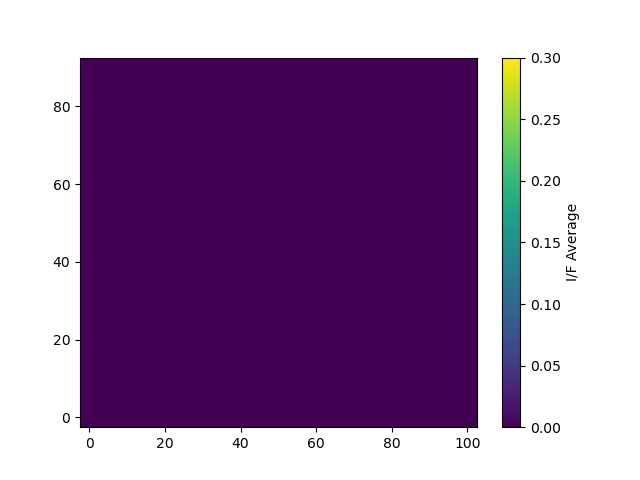

In [4]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'
vmin=0
vmax=0.3

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = finalMatrixHuygens[x][y][frame]
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Huygens Model. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [5]:
ani.pause()
plt.close()

## SIMLUATED MODELS 

The simulated models actually already exist as they were done artificially, they just need to be read in and displayed. No need for Tetrahedralization here!

In [6]:
X = 21 #incidence
Y = 19 #Emission
Z = 37 #Azimuth

dataWin5 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
#"win 5" means this is the fifth window, ie 2um.

with open('iephi_consolidate_2.01w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5[i][j][k] = float(row[i])
            if (math.isnan(dataWin5[i][j][k])):
                dataWin5[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1

dataWin5L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 

with open('iephi_consolidate_2.01wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5L[i][j][k] = float(row[i])
            if (math.isnan(dataWin5L[i][j][k])):
                dataWin5L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1

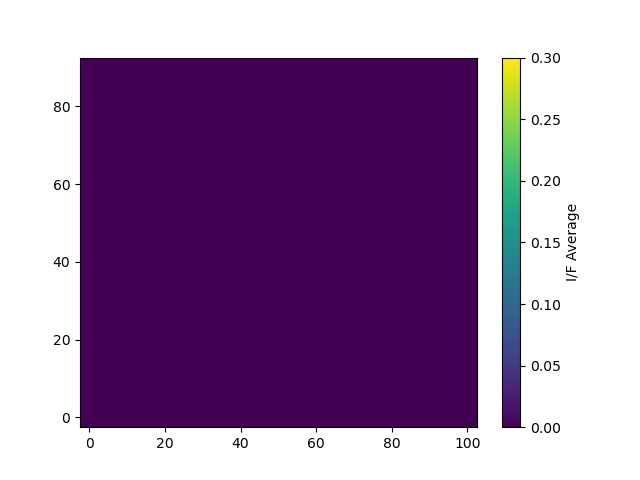

In [7]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = dataWin5[x][y][frame]*8 #There was an over-division in the processing for these models.
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Specular Sim Model. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [8]:
ani.pause()
plt.close()

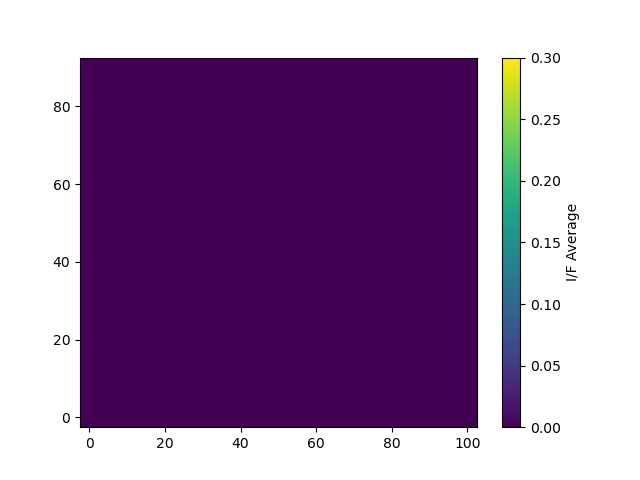

In [9]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = dataWin5L[x][y][frame]*8 #There was an over-division in the processing for these models.
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Lambertian Sim Model. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [10]:
ani.pause()
plt.close()

## NORTH POLE: SPECULAR AND LAMBERTIAN OLD DATA

While this data is not using the updated Mask, it is still what we were lookikng at once upon a time. So let's at least have it here for comparison later. 

In [11]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 17 #Value we select for. 17 should be 2um.

realBinsL = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsLNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #LAKES
realBinsS = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsSNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #"SURFACE"


#Read the data in, counting how many times we hit each bin.
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResults.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        if (float(row[11]) < 0):
            realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
            realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        else:
            realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
            realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        line_count += 1
i,j,k = 0,0,0
while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsSNum[i][j][k] != 0):
                realBinsS[i][j][k] = realBinsS[i][j][k] / float(realBinsSNum[i][j][k] )
            if (realBinsLNum[i][j][k] != 0):
                realBinsL[i][j][k] = realBinsL[i][j][k] / float(realBinsLNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1


In [12]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above notebook, but in actual use this will be
#defined or input some other way.
inputMatrix = realBinsS
inputMatrix2 = realBinsL

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

pointArray2 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                pointArray2.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh2 = pv.PolyData(pointArray2).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrixLake = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrixLake[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixLake[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixLake[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrixLand = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                finalMatrixLand[i][j][k] = inputMatrix2[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh2.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixLand[i][j][k] = -1
                    #Exterior Values get Negative'd
                else:
                    cell = mesh2.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix2[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixLand[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1
#print(finalMatrixLake)

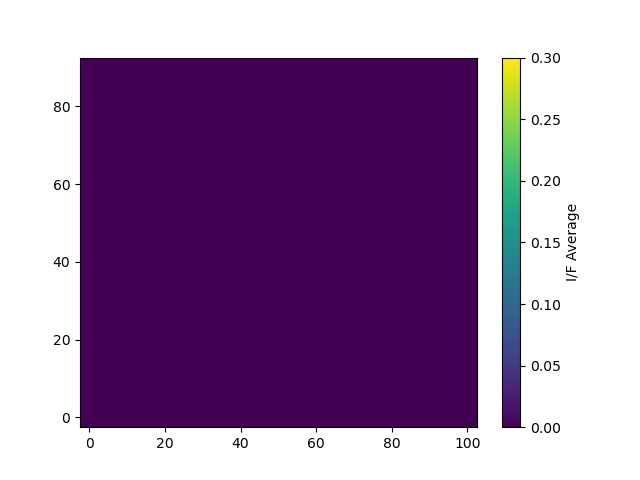

In [13]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = finalMatrixLake[x][y][frame] #There was an over-division in the processing for these models.
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'North Polar Lakes. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [14]:
ani.pause()
plt.close()

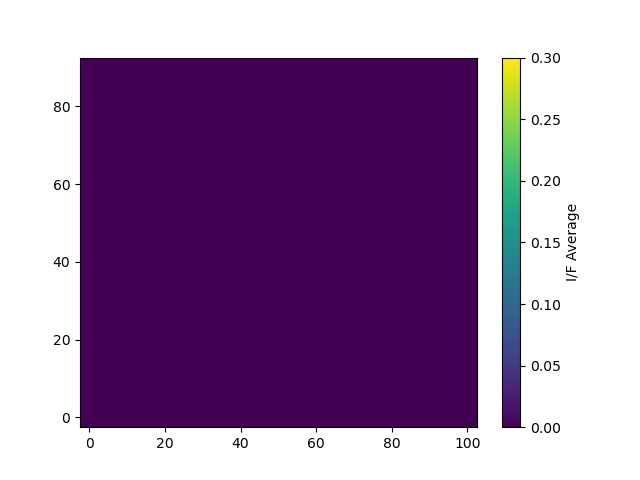

In [15]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = finalMatrixLand[x][y][frame] #There was an over-division in the processing for these models.
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'North Polar Land. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [16]:
ani.pause()
plt.close()

# DUNES AND PLAINS MODELS

The Hummocky and Cratery locations proved to not have many viable pixels, which is a shame. Xanadu proved to be rather reliable even at low accuracy, which is interesting.

However Dunes and Plains created wide models that were very inconsistent and jumped all over the place. Which means we need to be more restrictive, but when we're too restrictive we cause errors by inserting 0s into the otehrs. So to solve that we just deal with Plains and Dunes here.

In [17]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 17 #Value we select for. 17 should be 2um.

realBinsD = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsDNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #DUNES
realBinsP = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsPNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 

#Read the data in, counting how many times we hit each bin.
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResultsCLR.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        if((float(row[11]) > 150) and (float(row[10]) < 10)): #Only accept pixels of sufficient resolution and distance from a bad pixel. 
            if (row[2] == "Dunes"):
                realBinsDNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsDNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsD[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsD[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            elif (row[2] == "Plains"):
                realBinsPNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsPNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsP[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsP[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            #no else since we know there will be others we just don't carea bout.
i,j,k = 0,0,0
while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsDNum[i][j][k] != 0):
                realBinsD[i][j][k] = realBinsD[i][j][k] / float(realBinsDNum[i][j][k] )
            if (realBinsPNum[i][j][k] != 0):
                realBinsP[i][j][k] = realBinsP[i][j][k] / float(realBinsPNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1


In [18]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above cell. So yay!
inputMatrix = realBinsD
inputMatrix2 = realBinsP

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1
pointArray2 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                pointArray2.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh2 = pv.PolyData(pointArray2).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrixDunes = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrixDunes[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixDunes[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixDunes[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrixPlains = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                finalMatrixPlains[i][j][k] = inputMatrix2[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh2.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixPlains[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh2.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix2[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixPlains[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

#print(finalMatrixDunes)

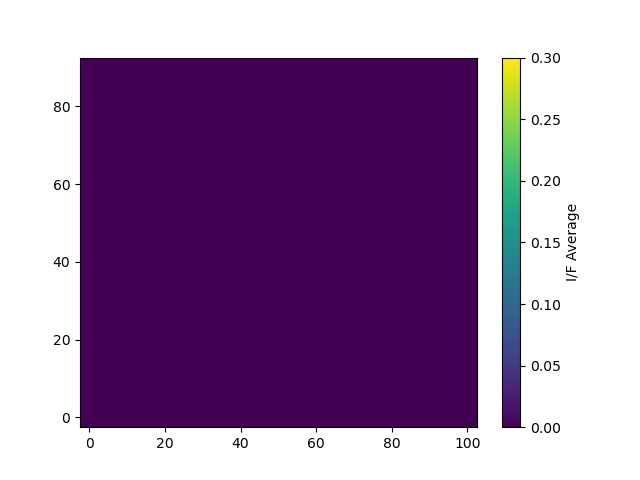

In [22]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'
vmin=0
vmax=0.3

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = finalMatrixDunes[x][y][frame]
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Equatorial Dunes Model. Azimuth: '+str(angles[frame])+ ' degrees')
    
ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [20]:
ani.pause()
plt.close()

In [21]:
np.save("DunesArray.npy", finalMatrixDunes)
np.save("PlainsArray.npy", finalMatrixPlains)

## EQUATORIAL REGION MODELS

Here we use models from the Equatorial Region. Here we will find a Dunes model, a Plains model, a Hummocky (Mountains) model, and a Xanadu model.

There are no Lakes or Labyrinths of sufficient distribution at the equator to have a single pixel marked as them.

In [39]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 17 #Value we select for. 17 should be 2um.

realBinsD = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsDNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #DUNES
realBinsP = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsPNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #PLAINS
realBinsH = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsHNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #HUMMOCKY
realBinsX = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsXNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #XANADU
realBinsC = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsCNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #CRATER (probably not useful but we need to catch all pixels anyway).


#Read the data in, counting how many times we hit each bin.
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResultsCLR.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        if((float(row[11]) > 50) and (float(row[10]) < 15)): #Only accept pixels of sufficient resolution and distance from a bad pixel. 
            if (row[2] == "Dunes"):
                realBinsDNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsDNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsD[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsD[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            elif (row[2] == "Plains"):
                realBinsPNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsPNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsP[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsP[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            elif (row[2] == "Hummocky"):
                realBinsHNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsHNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsH[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsH[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            elif (row[2] == "Xanadu"):
                realBinsXNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsXNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsX[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsX[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            elif (row[2] == "Crater"):
                realBinsCNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsCNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
                realBinsC[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsC[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
            else:
                print("Something went wrong with the classification somewhere bud.")    
            line_count += 1
i,j,k = 0,0,0
while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsDNum[i][j][k] != 0):
                realBinsD[i][j][k] = realBinsD[i][j][k] / float(realBinsDNum[i][j][k] )
            if (realBinsPNum[i][j][k] != 0):
                realBinsP[i][j][k] = realBinsP[i][j][k] / float(realBinsPNum[i][j][k] )
            if (realBinsHNum[i][j][k] != 0):
                realBinsH[i][j][k] = realBinsH[i][j][k] / float(realBinsHNum[i][j][k] )
            if (realBinsXNum[i][j][k] != 0):
                realBinsX[i][j][k] = realBinsX[i][j][k] / float(realBinsXNum[i][j][k] )
            if (realBinsCNum[i][j][k] != 0):
                realBinsC[i][j][k] = realBinsC[i][j][k] / float(realBinsCNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1


In [40]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above cell. So yay!
inputMatrix = realBinsD
inputMatrix2 = realBinsP
inputMatrix3 = realBinsH
inputMatrix4 = realBinsX
inputMatrix5 = realBinsC

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1
pointArray2 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                pointArray2.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1
pointArray3 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix3)):
    j = 0
    for y in range (len(inputMatrix3[0])):
        k = 0
        for z in range (len(inputMatrix3[0][0])):
            if (inputMatrix3[i][j][k] != 0):
                pointArray3.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1
pointArray4 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix4)):
    j = 0
    for y in range (len(inputMatrix4[0])):
        k = 0
        for z in range (len(inputMatrix4[0][0])):
            if (inputMatrix4[i][j][k] != 0):
                pointArray4.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1
pointArray5 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix5)):
    j = 0
    for y in range (len(inputMatrix5[0])):
        k = 0
        for z in range (len(inputMatrix5[0][0])):
            if (inputMatrix5[i][j][k] != 0):
                pointArray5.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh2 = pv.PolyData(pointArray2).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh3 = pv.PolyData(pointArray3).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh4 = pv.PolyData(pointArray4).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh5 = pv.PolyData(pointArray5).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrixDunes = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrixDunes[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixDunes[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixDunes[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrixPlains = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                finalMatrixPlains[i][j][k] = inputMatrix2[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh2.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixPlains[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh2.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix2[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixPlains[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrixHumm = [[[0 for x in range(len(inputMatrix3[0][0]))] for x in range(len(inputMatrix3[0]))] for x in range(len(inputMatrix3))]
i,j,k = 0,0,0
for x in range(len(inputMatrix3)):
    j = 0
    for y in range (len(inputMatrix3[0])):
        k = 0
        for z in range (len(inputMatrix3[0][0])):
            if (inputMatrix3[i][j][k] != 0):
                finalMatrixHumm[i][j][k] = inputMatrix3[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh3.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixHumm[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh3.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix3[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixHumm[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrixXanadu = [[[0 for x in range(len(inputMatrix4[0][0]))] for x in range(len(inputMatrix4[0]))] for x in range(len(inputMatrix4))]
i,j,k = 0,0,0
for x in range(len(inputMatrix4)):
    j = 0
    for y in range (len(inputMatrix4[0])):
        k = 0
        for z in range (len(inputMatrix4[0][0])):
            if (inputMatrix4[i][j][k] != 0):
                finalMatrixXanadu[i][j][k] = inputMatrix4[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh4.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrixXanadu[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh4.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix4[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrixXanadu[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

#We don't finalize a "crater" model as there's kind of no point.

#print(finalMatrixDunes)

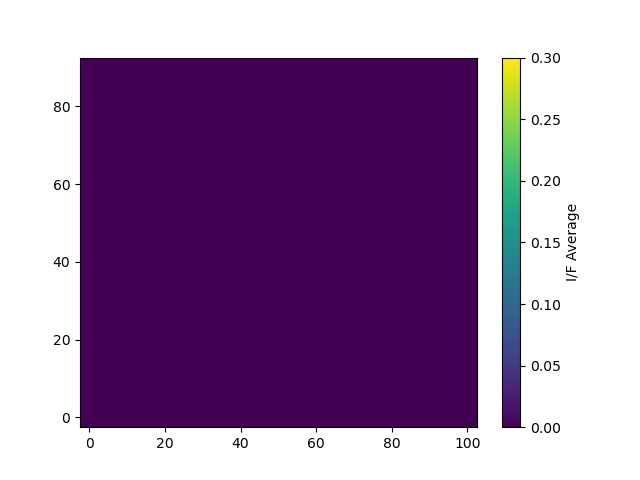

In [45]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'
vmin=0
vmax=0.3

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='I/F Average')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = finalMatrixPlains[x][y][frame]
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Equatorial Dunes Model. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [46]:
ani.pause()
plt.close()

In [ ]:
#np.save("HuygensArrayReduced2.npy", finalMatrixHuygens)

In [47]:
#finalMatrixHuygens Huygens Landing Site
#dataWin5 Specular Model
#dataWin5L Lambertian Model
#finalMatrixLake North Pole Lake Data
#finalMatrixLand North Pole Land Data

np.save("HuygensArray.npy", finalMatrixHuygens)
np.save("SpecularModelArray.npy", dataWin5)
np.save("LambertianModelArray.npy", dataWin5L)
np.save("NorthLakeArray.npy", finalMatrixLake)
np.save("NorthLandArray.npy", finalMatrixLand)

np.save("DunesArray.npy", finalMatrixDunes)
np.save("PlainsArray.npy", finalMatrixPlains)
np.save("HummockyArray.npy", finalMatrixHumm)
np.save("XanaduArray.npy", finalMatrixXanadu)

In [ ]:
plt.close()
import mpl_interactions.ipyplot as iplt
fig, ax = plt.subplots(figsize = (9,9), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

angleSpace = np.linspace(0, 180, 37)
inciSpace = np.linspace(0, 100, 21)
emisSpace = np.linspace(0, 90, 19)
azimSpace = np.linspace(0, 180, 37)
typeSpace = np.linspace(1,3,3)

def SM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5L[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5L[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5L[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LkD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixLake[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixLake[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixLake[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LnD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixLand[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixLand[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixLand[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixHuygens[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixHuygens[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixHuygens[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def eDunes(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixDunes[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixDunes[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixDunes[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def ePlains(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixPlains[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixPlains[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixPlains[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def eHumm(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixHumm[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixHumm[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixHumm[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def eXana(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrixXanadu[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrixXanadu[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrixXanadu[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

angleLabels = [0, 10, 20, 30, 40, 50, 60, 70,
             80, 90, 100, 110, 120, 130, 140, 150,
             160, 170, 180] 

ticker = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36]

controls = iplt.plot(SM, inci=inciSpace, emis=emisSpace, azim=azimSpace, types=typeSpace, ax = ax, label="Specular Model")
iplt.plot(LM, controls=controls, ax = ax, label="Lambertian Model")
#iplt.plot(LkD, controls=controls, ax = ax, label="North Pole Lake Data")
#iplt.plot(LnD, controls=controls, ax = ax, label="North Pole Land Data")
iplt.plot(SpecialD, controls=controls, ax = ax, label="Huygens Landing Site Data")
iplt.plot(eDunes, controls=controls, ax = ax, label="Equatorial Dunes Data")
iplt.plot(ePlains, controls=controls, ax = ax, label="Equatorial Plains Data")
#iplt.plot(eHumm, controls=controls, ax = ax, label="Equatorial Hummocky Data")
#iplt.plot(eXana, controls=controls, ax = ax, label="Equatorial Xanadu Data")
#iplt.plot(SpecialD2, controls=controls, ax = ax, label="New 2um Specular Model (Haze 2)")
ax.set(ylim = 0.0,xlabel = "Angle", ylabel = "I/F", xticks = ticker, xticklabels = angleLabels)
fig.legend()
#plt.savefig("TitanColorSchemes.tif", format="tif", bbox_inches='tight')

plt.show()

# EXTRA JUNK
## I didn't want to make an entirely new notebook

In [35]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 17 #Value we select for. 17 should be 2um.

#Our goal here is to separate the pixel results into different results for different places.
#Basically, following what we did to simplify the results down for Huygens.
#Fortunately the mask should already have cut down the number of pixels to consider considerably.

file1 = "pixelsFensal.csv"
file2 = "pixelsAztlan.csv"
file3 = "pixelsSenkyo.csv"
file4 = "pixelsBelet.csv"
file5 = "pixelsShangriLa.csv"
file6 = "pixelsXanaduA.csv"
file7 = "pixelsXanaduB.csv"

with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResultsCLR.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        outline = str(row[0]) + "," + str(row[1]) + "," + str(row[2]) + "," + str(row[3]) + "," + str(row[4]) + "," + str(row[5]) + "," + str(row[6]) + "," + str(row[7]) + "," + str(row[8]) + "," + str(row[9]) + "," + str(row[10]) + "," + str(row[11]) + "," + str(row[12]) + "," + str(row[13]) + "," + str(row[14]) + "," + str(row[15]) +  "," + str(row[16]) + "," + str(row[17]) + "," + str(row[18]) + "," + str(row[19]) + "," + str(row[20]) + "\n"
        #CONDITIONS FOR ACCEPTANCE:
        #2) Within 1 degree of latlon from orignal point. (a little more leeway than with Huygens).
        if((float(row[5]) > 6 and float(row[5]) < 8) and (float(row[6]) > 59 and float(row[6]) < 61)):
            with open(file1, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -10 and float(row[5]) < -8) and (float(row[6]) > 6 and float(row[6]) < 8)):
            with open(file2, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -7 and float(row[5]) < -5) and (float(row[6]) > 335 and float(row[6]) < 337)):
            with open(file3, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -6 and float(row[5]) < -4) and (float(row[6]) > 243 and float(row[6]) < 245)):
            with open(file4, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -8 and float(row[5]) < -6) and (float(row[6]) > 159 and float(row[6]) < 161)):
            with open(file5, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -2 and float(row[5]) < 0) and (float(row[6]) > 115 and float(row[6]) < 117)):
            with open(file6, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        elif((float(row[5]) > -17 and float(row[5]) < -15) and (float(row[6]) > 114 and float(row[6]) < 116)):
            with open(file7, 'a') as dataEntry: #w for write
                dataEntry.write(outline)
        
        line_count += 1



